# Belgium Real Estate Prediction Model

On a previous Red Line Project stage a Belgium's real estate dataset of 75k+ observations were scrapped from immoweb.be and analized.

This notebook is designed to data preprocessing for the further using this data in the machine learning model for predicting price.


In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Load the data
data_input = pd.read_csv('data/properties.csv')
print(data_input.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75511 entries, 0 to 75510
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              75511 non-null  int64  
 1   price                           75511 non-null  float64
 2   property_type                   75511 non-null  object 
 3   subproperty_type                75511 non-null  object 
 4   region                          75511 non-null  object 
 5   province                        75511 non-null  object 
 6   locality                        75511 non-null  object 
 7   zip_code                        75511 non-null  int64  
 8   latitude                        61413 non-null  float64
 9   longitude                       61413 non-null  float64
 10  construction_year               42120 non-null  float64
 11  total_area_sqm                  67896 non-null  float64
 12  surface_land_sqm                

In [2]:
# Print the column names
print(data_input.columns)

Index(['id', 'price', 'property_type', 'subproperty_type', 'region',
       'province', 'locality', 'zip_code', 'latitude', 'longitude',
       'construction_year', 'total_area_sqm', 'surface_land_sqm',
       'nbr_frontages', 'nbr_bedrooms', 'equipped_kitchen', 'fl_furnished',
       'fl_open_fire', 'fl_terrace', 'terrace_sqm', 'fl_garden', 'garden_sqm',
       'fl_swimming_pool', 'fl_floodzone', 'state_building',
       'primary_energy_consumption_sqm', 'epc', 'heating_type',
       'fl_double_glazing', 'cadastral_income'],
      dtype='object')


##### Removing duplicates

In [3]:
duplicates = data_input.duplicated(subset='id', keep='first')
duplicated_rows = data_input[duplicates]
print(f"Number of duplicated ids found:\n{duplicated_rows['id'].count()}")

Number of duplicated ids found:
26694


In [4]:
# Exclude the first column from duplicate check
columns_to_check = data_input.columns[1:]

# Find duplicates in rows except the first column
duplicates = data_input.duplicated(subset=columns_to_check, keep='first')

# Filter the dataset to show only the duplicated rows (excluding the first occurrence)
duplicated_rows = data_input[duplicates]
print(f"Number of duplicated rows found:\n{duplicated_rows['id'].count()}")

# Remove duplicate rows based on specified columns
data = data_input.drop_duplicates(subset=columns_to_check, keep='first')

# Display the cleaned dataset
print(f'Dataset number of ids (excluding duplicate rows): \n{data['id'].count()}')

Number of duplicated rows found:
3
Dataset number of ids (excluding duplicate rows): 
75508


##### Missing data management

In [5]:
# Check for missing data in numerical columns
missing_data_numerical_columns = data.columns[data.isna().any()]
print(data[missing_data_numerical_columns].isna().sum())

latitude                          14098
longitude                         14098
construction_year                 33388
total_area_sqm                     7615
surface_land_sqm                  36253
nbr_frontages                     26346
terrace_sqm                       13140
garden_sqm                         2939
primary_energy_consumption_sqm    26566
cadastral_income                  44964
dtype: int64


In [6]:
# Check the consistency of the 'terrace_sqm' data
print(data['terrace_sqm'].isna().groupby(data['fl_terrace']).sum())
print(data[data['terrace_sqm'] == 0].groupby(data['fl_terrace'])['terrace_sqm'].count())

fl_terrace
0        0
1    13140
Name: terrace_sqm, dtype: int64
fl_terrace
0    30896
Name: terrace_sqm, dtype: int64


In [7]:
# Check the consistency of the 'garden_sqm' data
print(data['garden_sqm'].isna().groupby(data['fl_garden']).sum())
print(data[data['garden_sqm'] == 0].groupby(data['fl_garden'])['garden_sqm'].count())

fl_garden
0       0
1    2939
Name: garden_sqm, dtype: int64
fl_garden
0    59025
Name: garden_sqm, dtype: int64


In [8]:
# Drop inconsistent garden and terrace data
data = data.drop(data[(data['garden_sqm'] > data['surface_land_sqm']) | (data['terrace_sqm'] > 
                 data['surface_land_sqm'])].index)
print(f'Dataset number of ids (excluding dropped rows): \n{data['id'].count()}')

Dataset number of ids (excluding dropped rows): 
73812


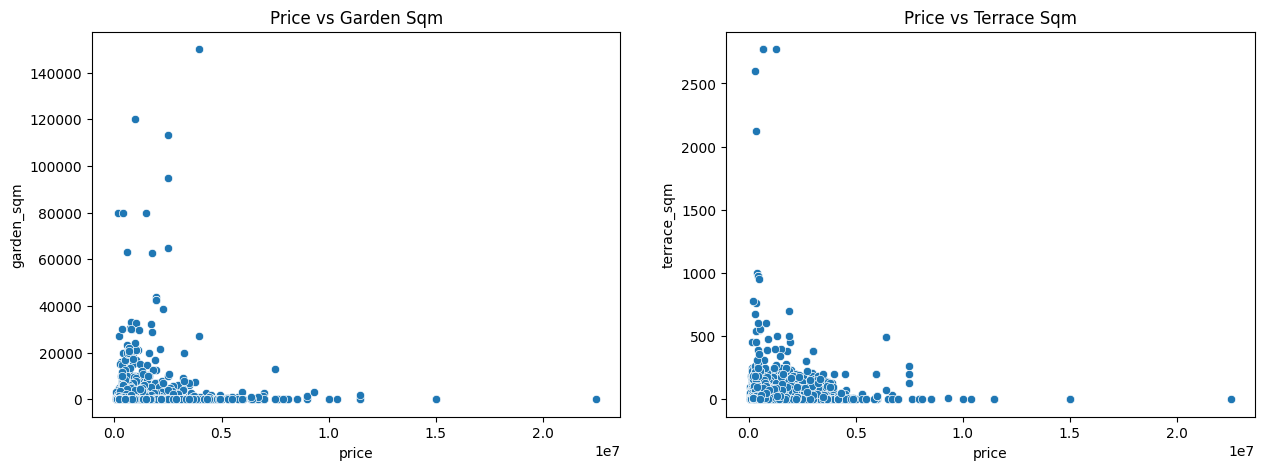

In [9]:
# Visualize the distribution of the 'price' column and 'garde_sqm'/'terrace_sqm' columns
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(x='price', y='garden_sqm', data=data, ax=ax[0])
sns.scatterplot(x='price', y='terrace_sqm', data=data, ax=ax[1])
ax[0].set_title('Price vs Garden Sqm')
ax[1].set_title('Price vs Terrace Sqm')
plt.show()

In [10]:
from sklearn.impute import SimpleImputer

# Impute missing values in 'terrace_sqm' and 'garden_sqm' columns with the mean
imputer = SimpleImputer(strategy='mean')
imputer.fit(data[['terrace_sqm']])
data['terrace_sqm'] = imputer.transform(data[['terrace_sqm']])
print(data['terrace_sqm'].isna().sum())
imputer.fit(data[['garden_sqm']])
data['garden_sqm'] = imputer.transform(data[['garden_sqm']])
print(data['garden_sqm'].isna().sum())

0
0


In [11]:
print(data.dtypes)

id                                  int64
price                             float64
property_type                      object
subproperty_type                   object
region                             object
province                           object
locality                           object
zip_code                            int64
latitude                          float64
longitude                         float64
construction_year                 float64
total_area_sqm                    float64
surface_land_sqm                  float64
nbr_frontages                     float64
nbr_bedrooms                      float64
equipped_kitchen                   object
fl_furnished                        int64
fl_open_fire                        int64
fl_terrace                          int64
terrace_sqm                       float64
fl_garden                           int64
garden_sqm                        float64
fl_swimming_pool                    int64
fl_floodzone                      

In [12]:
# Check the consistency of the 'surface_land_sqm' data
print(data['surface_land_sqm'].isna().groupby(data['property_type']).sum())
print(data[data['surface_land_sqm'] == 0].groupby(data['property_type'])['surface_land_sqm'].count())
print(data[data['surface_land_sqm'] < 0].groupby(data['property_type'])['surface_land_sqm'].count())

property_type
APARTMENT    36253
HOUSE            0
Name: surface_land_sqm, dtype: int64
property_type
HOUSE    3107
Name: surface_land_sqm, dtype: int64
Series([], Name: surface_land_sqm, dtype: int64)


In [13]:
# Fill missing values in 'surface_land_sqm' column with 0
data = data.fillna(value={'surface_land_sqm': 0})
print(data['surface_land_sqm'].isna().sum())

0


In [14]:
# Check the consistency of the 'primary_energy_consumption_sqm' and 'epc' data
# Check for negative and zero values
print(sorted(data[data['primary_energy_consumption_sqm'].notna()]['primary_energy_consumption_sqm'].unique()))
negative_pec = data[data['primary_energy_consumption_sqm'] < 0] 
print(negative_pec.groupby(['region', 'epc'])['primary_energy_consumption_sqm'].count())
zero_pec = data[data['primary_energy_consumption_sqm'] == 0] 
print(zero_pec.groupby(['region', 'epc'])['primary_energy_consumption_sqm'].count())
# Drop the rows with zero 'primary_energy_consumption_sqm' and missing 'epc' values
zero_drop = zero_pec[zero_pec['epc'] == 'MISSING']
data = data.drop(zero_drop.index)
print(data['id'].count())

[-140.0, -99.0, -74.0, -56.0, -50.0, -48.0, -39.0, -36.0, -35.0, -30.0, -22.0, -21.0, -18.0, -15.0, -13.0, -11.0, -10.0, -9.0, -8.0, -7.0, -6.0, -5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 3.4, 4.0, 5.0, 5.47, 6.0, 7.0, 8.0, 8.16, 9.0, 10.0, 11.0, 12.0, 12.48, 13.0, 14.0, 15.0, 16.0, 16.65, 17.0, 18.0, 18.2, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 25.91, 26.0, 26.51, 26.57, 27.0, 28.0, 28.84, 29.0, 29.67, 30.0, 30.03, 30.76, 31.0, 31.14, 32.0, 32.89, 33.0, 33.37, 33.67, 34.0, 34.52, 35.0, 35.05, 36.0, 36.57, 36.6, 36.68, 37.0, 38.0, 39.0, 39.03, 39.28, 39.5, 39.83, 40.0, 40.47, 40.92, 41.0, 42.0, 43.0, 43.16, 43.54, 44.0, 44.2, 44.87, 45.0, 46.0, 46.1, 46.42, 47.0, 47.15, 47.45, 47.85, 47.91, 48.0, 48.68, 48.84, 49.0, 50.0, 50.52, 50.92, 51.0, 51.8, 52.0, 52.12, 52.19, 53.0, 53.26, 53.84, 53.91, 54.0, 55.0, 55.54, 56.0, 56.97, 57.0, 57.78, 58.0, 58.9, 59.0, 59.81, 59.85, 59.86, 60.0, 60.67, 61.0, 61.38, 62.0, 62.1, 62.16, 63.0, 63.5, 64.0, 65.0, 65.6, 66.0, 66.81, 67.0, 67.16, 

In [15]:
# Check for big values
big_pec = data[data['primary_energy_consumption_sqm'] > 550]
print(big_pec.groupby('epc')['primary_energy_consumption_sqm'].count())
print(big_pec.groupby(['region', 'epc'])['primary_energy_consumption_sqm'].count())
print(data[data['primary_energy_consumption_sqm'].notna()].groupby('primary_energy_consumption_sqm')
['primary_energy_consumption_sqm'].nunique())

epc
A         6
A+        3
A++      16
B        13
C        19
D        15
E        23
F      3187
G      2021
Name: primary_energy_consumption_sqm, dtype: int64
region            epc
Brussels-Capital  G       396
Flanders          A         2
                  A++      15
                  B         1
                  D         1
                  E         5
                  F      3179
                  G         8
Wallonia          A         4
                  A+        3
                  A++       1
                  B        12
                  C        19
                  D        14
                  E        18
                  F         8
                  G      1617
Name: primary_energy_consumption_sqm, dtype: int64
primary_energy_consumption_sqm
-140.0         1
-99.0          1
-74.0          1
-56.0          1
-50.0          1
              ..
 190525.0      1
 2994164.0     1
 20210904.0    1
 20230411.0    1
 20231122.0    1
Name: primary_energy_consumption_sqm

In [16]:
# Check the consistency of the 'epc' and 'primary_energy_consumption_sqm' data in Flanders
filtered_data = data[(data['region'].isin(['Flanders'])) & (
                     ((data['primary_energy_consumption_sqm'] >= 0) & (data['primary_energy_consumption_sqm'] <= 100) 
                     & (~data['epc'].isin(['A']))) |
                     ((data['primary_energy_consumption_sqm'] > 100) & (data['primary_energy_consumption_sqm'] <= 200) 
                     & (~data['epc'].isin(['B']))) |
                     ((data['primary_energy_consumption_sqm'] > 200) & (data['primary_energy_consumption_sqm'] <= 300) 
                     & (~data['epc'].isin(['C']))) |
                     ((data['primary_energy_consumption_sqm'] > 300) & (data['primary_energy_consumption_sqm'] <= 400) 
                     & (~data['epc'].isin(['D']))) |
                     ((data['primary_energy_consumption_sqm'] > 400) & (data['primary_energy_consumption_sqm'] <= 500) 
                     & (~data['epc'].isin(['E']))) |
                     ((data['primary_energy_consumption_sqm'] > 500) & (~data['epc'].isin(['F'])))
                     )]
print(filtered_data.groupby(['region', 'epc'])['primary_energy_consumption_sqm'].count())
# Drop the inconsistent rows
data = data.drop(filtered_data.index)
print(f'Dataset number of ids (excluding dropped rows): \n{data['id'].count()}')

region    epc
Flanders  A       19
          A+      51
          A++    256
          B       31
          C       36
          D       19
          E       13
          F       16
          G        8
Name: primary_energy_consumption_sqm, dtype: int64
Dataset number of ids (excluding dropped rows): 
71523


In [17]:
# Check the consistency of the 'epc' and 'primary_energy_consumption_sqm' data in Brussels
filtered_data = data[(data['region'].isin(['Brussels'])) & (
                     ((data['primary_energy_consumption_sqm'] >= 0) & (data['primary_energy_consumption_sqm'] <= 45) 
                     & (~data['epc'].isin(['A']))) |
                     ((data['primary_energy_consumption_sqm'] > 45) & (data['primary_energy_consumption_sqm'] <= 95) 
                     & (~data['epc'].isin(['B']))) |
                     ((data['primary_energy_consumption_sqm'] > 95) & (data['primary_energy_consumption_sqm'] <= 150) 
                     & (~data['epc'].isin(['C']))) |
                     ((data['primary_energy_consumption_sqm'] > 150) & (data['primary_energy_consumption_sqm'] <= 210) 
                     & (~data['epc'].isin(['D']))) |
                     ((data['primary_energy_consumption_sqm'] > 210) & (data['primary_energy_consumption_sqm'] <= 280) 
                     & (~data['epc'].isin(['E']))) |
                     ((data['primary_energy_consumption_sqm'] > 280) & (data['primary_energy_consumption_sqm'] <= 350) 
                     & (~data['epc'].isin(['F']))) |
                     ((data['primary_energy_consumption_sqm'] > 350) & (~data['epc'].isin(['G'])))
                     )]
print(filtered_data.groupby(['region', 'epc'])['primary_energy_consumption_sqm'].count())
# Drop the inconsistent rows
data = data.drop(filtered_data.index)
print(f'Dataset number of ids (excluding dropped rows): \n{data['id'].count()}')

Series([], Name: primary_energy_consumption_sqm, dtype: int64)
Dataset number of ids (excluding dropped rows): 
71523


In [18]:
# Check the consistency of the 'epc' and 'primary_energy_consumption_sqm' data in Wallonia
filtered_data = data[(data['region'].isin(['Wallonia'])) & (
                     ((data['primary_energy_consumption_sqm'] >= 0) & (data['primary_energy_consumption_sqm'] <= 45) 
                     & (~data['epc'].isin(['A']))) |
                     ((data['primary_energy_consumption_sqm'] > 45) & (data['primary_energy_consumption_sqm'] <= 170) 
                     & (~data['epc'].isin(['B']))) |
                     ((data['primary_energy_consumption_sqm'] > 170) & (data['primary_energy_consumption_sqm'] <= 260) 
                     & (~data['epc'].isin(['C']))) |
                     ((data['primary_energy_consumption_sqm'] > 260) & (data['primary_energy_consumption_sqm'] <= 340) 
                     & (~data['epc'].isin(['D']))) |
                     ((data['primary_energy_consumption_sqm'] > 340) & (data['primary_energy_consumption_sqm'] <= 425) 
                     & (~data['epc'].isin(['E']))) |
                     ((data['primary_energy_consumption_sqm'] > 425) & (data['primary_energy_consumption_sqm'] <= 510) 
                     & (~data['epc'].isin(['F']))) |
                     ((data['primary_energy_consumption_sqm'] > 510) & (~data['epc'].isin(['G'])))
                     )]
print(filtered_data.groupby(['region', 'epc'])['primary_energy_consumption_sqm'].count())
# Drop the inconsistent rows
data = data.drop(filtered_data.index)
print(f'Dataset number of ids (excluding dropped rows): \n{data['id'].count()}')

region    epc
Wallonia  A      1487
          A+      384
          A++       9
          B        17
          C        40
          D       149
          E        35
          F        18
          G         9
Name: primary_energy_consumption_sqm, dtype: int64
Dataset number of ids (excluding dropped rows): 
69375


In [19]:
# Replace zero values in 'primary_energy_consumption_sqm' with NaN only for specific EPC ratings
data.loc[(data['primary_energy_consumption_sqm'] == 0) & (~data['epc'].isin(['A++', 'A+', 
            'A'])), 'primary_energy_consumption_sqm'] = np.nan

# Calculate the mean 'primary_energy_consumption_sqm' for each 'region' and 'epc' group
# and fill NaN values in 'primary_energy_consumption_sqm' with these means
data['primary_energy_consumption_sqm'] = data.groupby(['region', 'epc'])['primary_energy_consumption_sqm']\
    .transform(lambda x: x.fillna(x.mean()))

# If there are still any NaN values in 'primary_energy_consumption_sqm' (e.g., all values in a group are NaN),
# fill them with a global mean or another placeholder value:
global_mean = data['primary_energy_consumption_sqm'].mean()
data['primary_energy_consumption_sqm'] = data['primary_energy_consumption_sqm'].fillna(global_mean)

print(data['primary_energy_consumption_sqm'].isna().sum())

In [22]:
print(data['equipped_kitchen'].unique())

['INSTALLED' 'MISSING' 'HYPER_EQUIPPED' 'NOT_INSTALLED' 'USA_UNINSTALLED'
 'USA_HYPER_EQUIPPED' 'SEMI_EQUIPPED' 'USA_INSTALLED' 'USA_SEMI_EQUIPPED']


In [21]:
kitchen_map = {
            'HYPER_EQUIPPED': 'INSTALLED',
            'SEMI_EQUIPPED': 'INSTALLED',
            'USA_HYPER_EQUIPPED': 'INSTALLED',
            'USA_INSTALLED': 'INSTALLED',
            'USA_SEMI_EQUIPPED': 'INSTALLED',
            'USA_UNINSTALLED': 'NOT_INSTALLED',
        }
# Remap
data["equipped_kitchen_short"] = data["equipped_kitchen"].map(kitchen_map)

0


In [ ]:
# Again check for big values
big_pec = data[data['primary_energy_consumption_sqm'] > 550]
print(big_pec.groupby(['region', 'epc'])['primary_energy_consumption_sqm'].count())

In [ ]:
# Check for too big values
too_big_pec = data[data['primary_energy_consumption_sqm'] > 1200]
print(too_big_pec.groupby(['region', 'epc'])['primary_energy_consumption_sqm'].count())
# Drop the inconsistent rows
data = data.drop(too_big_pec.index)
print(f'Dataset number of ids (excluding dropped rows): \n{data['id'].count()}')

In [ ]:
# Again check for missing data in numerical columns
missing_data_numerical_columns = data.columns[data.isna().any()]
print(data[missing_data_numerical_columns].isna().sum())

In [ ]:
# Drop rows with missing region data
data = data[data['region'] != 'MISSING']
print(f'Dataset number of ids (excluding dropped rows): \n{data["id"].count()}')
# Check for missing data in categorical columns
missing_data_categorical_columns = data.columns[data.isin(['MISSING']).any()]
print(data[missing_data_categorical_columns].isin(['MISSING']).sum())

In [ ]:
# Check missing values in 'epc' and 'primary_energy_consumption_sqm' columns
print(data[data['epc'] == 'MISSING']['id'].count())
print(data[data['primary_energy_consumption_sqm'].isna()]['id'].count())
print(data[(data['epc'] == 'MISSING') & (data['primary_energy_consumption_sqm'].isna())]['id'].count())
# Drop rows with missing 'epc' and 'primary_energy_consumption_sqm' values
data = data.drop(data[(data['epc'] == 'MISSING') & (data['primary_energy_consumption_sqm'].isna())].index)
print(f'Dataset number of ids (excluding dropped rows): \n{data["id"].count()}')

In [ ]:
# Again check missing values in 'epc' and 'primary_energy_consumption_sqm' columns
print(data[data['epc'] == 'MISSING']['id'].count())
print(data[data['primary_energy_consumption_sqm'].isna()]['id'].count())
print(data['epc'].unique())
print(data['region'].unique())

In [ ]:
# Imputing missing values in 'primary_energy_consumption_sqm' columns
imputer = SimpleImputer(strategy='mean')

# Calculate a global fallback median value
global_fallback_value = data['primary_energy_consumption_sqm'].median()

# Define a custom imputation function
def custom_impute(series):
    if series.isna().all():
        # For completely missing groups, return the fallback value
        return pd.Series([global_fallback_value]*len(series), index=series.index)
    else:
        # Normal imputation for groups with at least some non-NaN values
        reshaped_series = series.values.reshape(-1, 1)
        imputed_values = imputer.fit_transform(reshaped_series).ravel()
        return pd.Series(imputed_values, index=series.index)

# Apply the custom imputation, considering the new logic for all-NaN groups
data['primary_energy_consumption_sqm'] = data.groupby(['region', 
        'epc'])['primary_energy_consumption_sqm'].transform(custom_impute)

# Again check missing values in 'primary_energy_consumption_sqm' column
print(data[data['primary_energy_consumption_sqm'].isna()]['id'].count())

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of the 'primary_energy_consumption_sqm' data
epc_labels = ['G', 'F', 'E', 'D', 'C', 'B', 'A', 'A+', 'A++']
sns.relplot(data=data, x='epc', y='primary_energy_consumption_sqm', 
                hue='region', palette='coolwarm', kind='scatter', height=6, aspect=1.6
               )
plt.xlabel('EPC')
plt.ylabel('Primary Energy Consumption (kWh/m²/year)')
plt.title('Distribution of the Primary Energy Consumption')
plt.show()

In [28]:
print(data['nbr_bedrooms'].unique())
print(data['total_area_sqm'].isna().sum())
# Drop rows with missing 'total_area_sqm' values
data = data.drop(data[data['total_area_sqm'].isna()].index)

[  2.   3.   1.   4.   6.   7.   5.   0.  20.  10.   9.   8.  19.  13.
  14.  12.  15.  27.  25.  16.  30.  21.  11.  18.  17.  22.  24.  39.
  47.  36.  48. 200.  31.  34.  90.  40.  44.  35.  28. 100.  23.  37.
  41.  70.  45.  60.]
6907


In [30]:
print(data['state_building'].unique())
print(data[data['state_building'] == 'MISSING']['id'].count())

['MISSING' 'AS_NEW' 'GOOD' 'TO_RENOVATE' 'TO_BE_DONE_UP' 'JUST_RENOVATED'
 'TO_RESTORE']
23959


In [23]:
# Check for missing data in categorical columns
missing_data_categorical_columns = data.columns[data.isin(['MISSING']).any()]
print(data[missing_data_categorical_columns].isin(['MISSING']).sum())

region                  3
province                3
locality                3
equipped_kitchen    29950
state_building      23959
epc                 21619
heating_type        28017
dtype: int64


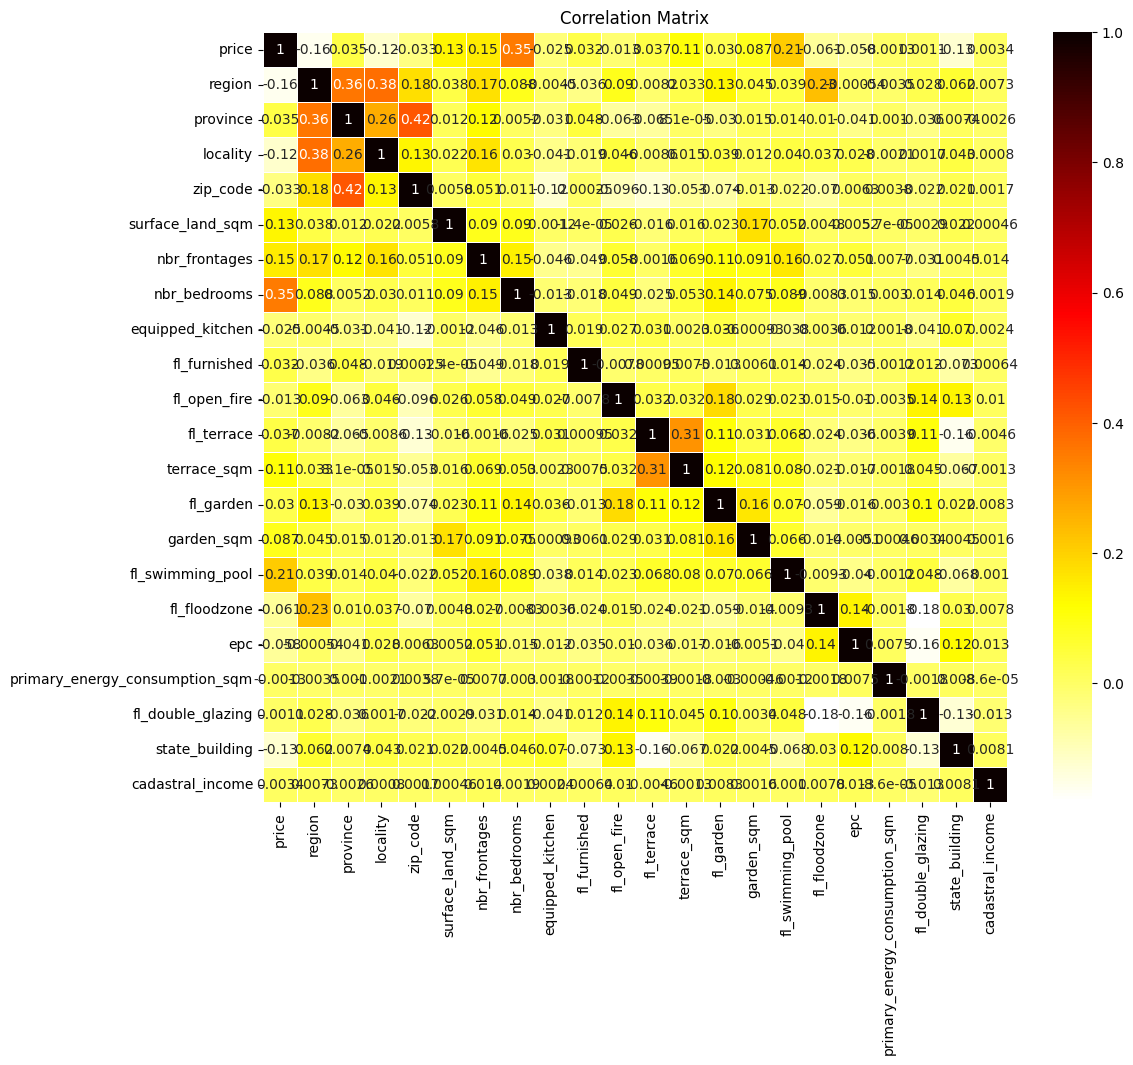

In [31]:
# Visualize the heatmap of the correlation matrix
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
data_temp = data.copy()
for col in categorical_cols:
    data_temp[col] = label_encoder.fit_transform(data_temp[col])
columns_to_show = ['price', 'region', 'province', 'locality', 'zip_code', 'surface_land_sqm', 
       'nbr_frontages', 'nbr_bedrooms', 'equipped_kitchen', 'fl_furnished', 'fl_open_fire',  
       'fl_terrace', 'terrace_sqm', 'fl_garden', 'garden_sqm', 'fl_swimming_pool', 'fl_floodzone', 
       'epc','primary_energy_consumption_sqm', 'fl_double_glazing', 'state_building', 'cadastral_income']
plt.figure(figsize=(12, 10))
sns.heatmap(data_temp[columns_to_show].corr(), annot=True, cmap='hot_r', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
from scipy.stats import zscore

# Select only numerical columns (both float and int)
numerical_cols = data.select_dtypes(include=["float64", "int64"]).columns
# Calculate z-scores for the entire DataFrame but only for numerical columns
z_scores = np.abs(data[numerical_cols].apply(zscore, nan_policy='omit'))
# Prepare a mask for outliers: z-score > 3
outliers_mask = (z_scores > 3).any(axis=1) & (data["property_type"] != 
                "HOUSE") & (data["property_type"] != "APARTMENT")
# Drop rows where any numerical column has a z-score > 3, excluding 'HOUSE' and 'APARTMENT' types from this criterion
data = data[~outliers_mask]
print(f'Dataset number of ids (excluding outliers): \n{data["id"].count()}')

In [ ]:
data.drop(columns=['id', 'subproperty_type', 'region', 'province', 'locality', 'latitude', 'longitude',
    'total_area_sqm', 'nbr_frontages', 'terrace_sqm', 'garden_sqm', 'fl_floodzone', 'primary_energy_consumption_sqm',
    'cadastral_income'], inplace=True)

In [ ]:
# Filling columns with 0 instead of NaN
data.fillna(value={'Has_Terrace': 0, 'Has_Garden': 0, 'Facade_Count': 0, 'Double_glazing': 0, 
                   'Swimming_Pool': 0, 'Indoor_Parking': 0, 'Outdoor_Parking': 0, 'Land_Surface': 0}, inplace=True)

# Converting Double_glazing values to int
data['Double_glazing'] = data['Double_glazing'].astype(int)

# Convert specified columns to numeric, coercing errors to NaN
columns_to_convert = ['Price','Construction_Year', 'Bedroom_Count', 'Terrace_Surface','Garden_Surface', 
                      'Land_Surface', 'Facade_Count', 'Double_glazing']
data[columns_to_convert] = data[columns_to_convert].apply(pd.to_numeric, errors='coerce')

# Removee the postal codes, which not belong to Belgium
data = data.loc[data['Postal_Code'] < 10000]

print(data.isna().sum())

#### Removing duplicates

In [ ]:
# Exclude the first column from duplicate check
columns_to_check = data.columns[1:8]
columns_to_check.append(data.columns[10:])

# Remove duplicate rows based on specified columns
data = data.drop_duplicates(subset=columns_to_check, keep='first')

# Display the cleaned dataset
print(f'Cleaned Dataset (excluding duplicate rows): \n{data.count()}')

In [ ]:
# Find rows that have all the columns filled
filled_rows = data[data.notna().all(axis=1)]
print(filled_rows)

In [ ]:
# Save the cleaned dataset
data.to_csv("immoweb_cleaned.csv", index=False)

In [ ]:
print(data.describe())  # Summary statistics
print(data.info())      # Information about the dataset

#### Data Analysis

In [ ]:
# Add the region
region = lambda code: 'Brussels' if code < 1300 else ('Wallonia' if code in range(1300, 1500) or code \
            in range(4000, 8000) else 'Flanders')
data['Region'] = data['Postal_Code'].apply(region)
print(data['Region'].value_counts())

In [ ]:
# Add the province
province = lambda code: 'Brussels Capital Region' if code < 1300 else ('Walloon Brabant' if code in range(1300, 1500) \
            else ('Flemish Brabant' if code in range(1500, 2000) or code in range(3000, 3500) else ('Antwerp' if \
            code in range(2000, 3000) else ('Limburg' if code in range(3500, 4000) else ('Liege' if code in \
            range(4000, 5000) else ('Namur' if code in range(5000, 6000) else ('Luxembourg' if code in \
            range(6600, 7000) else ('West Flanders' if code in range(8000, 9000) else (('East Flanders' \
            if code in range(9000, 10000) else 'Hainaut'))))))))))
data['Province'] = data['Postal_Code'].apply(province)
print(data['Province'].value_counts())

In [ ]:
# Add a column for the price per square meter
data['Price_m2'] = data['Price'] / (data['Habitable_Surface'] + data['Land_Surface'])
print(data.groupby(['Region', 'Province'])['Price_m2'].mean().round(1))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Remove outliers
data = data[data['Price_m2'] <= 40000]
data = data[data['Bedroom_Count'] <= 40]

order = ['Brussels Capital Region', 'West Flanders', 'Flemish Brabant', 'Antwerp', 'Walloon Brabant', \
         'East Flanders', 'Limburg', 'Luxembourg', 'Namur', 'Liege', 'Hainaut']
sns.set_palette(['orange', 'yellow', 'red'])
hue_order = ['Brussels', 'Flanders', 'Wallonia']
sns.catplot(x='Province', y='Price_m2', data=data, kind='box', order=order, hue='Region', hue_order=hue_order,\
            height=8, aspect=1.5)
plt.title("Distribution of prices for propeties across the provinces")
plt.ylabel("Price in € per m2")
plt.xticks(rotation=45)
plt.show()

In [ ]:
sns.catplot(x='Postal_Code', y='Price_m2', data=data[data['Province']=="West Flanders"], kind='box', \
                height=8, aspect=1.7)
plt.title("Distribution of prices per m2 for propeties across postal codes in West Flanders")
plt.ylabel("Price in € per m2")
plt.xlabel("Postal code")
plt.xticks(rotation=90)
plt.show()

In [ ]:
plt.subplots(figsize=(12, 8))
sns.stripplot(x='Price', y='Bedroom_Count', data=data, hue='Type', palette='Set1', jitter=True)
plt.show()

In [ ]:
sns.relplot(x='Price', y='Bedroom_Count', data=data, kind='scatter', col='Type', hue='Type', palette='Set1',\
            size='Price_m2')
plt.show()

In [ ]:
mask = (data['Type'] == 'HOUSE') & ((data['Price'] >= 1200000) | (data['Bedroom_Count'] > 20))
data = data[~mask]

sns.relplot(x='Price', y='Bedroom_Count', data=data, kind='scatter', col='Region', palette='Set1', hue='Type')
plt.show()

In [ ]:
# Divide the data into separete datasets for houses and apartments
data_houses = data[data['Type'] == 'HOUSE']
data_apartments = data[data['Type'] == 'APARTMENT']
data_apartments.drop(columns='Land_Surface', inplace=True)
print(data['Type'].value_counts())

#### Creating a map with data on price per square meter

In [ ]:
# Impost the necessary libraries for creating a map
import geopandas as gpd
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

# Preparing the map for houses
houses = data_houses.loc[:, ('ID', 'Postal_Code', 'Price', 'Price_m2', 'Latitude', 'Longitude', 'Region', 'Province')]
houses = houses.dropna(subset=['Latitude', 'Longitude'])
houses = houses.drop_duplicates(subset=['Latitude', 'Longitude'])

houses_mean = pd.concat([houses.groupby(['Postal_Code'])['Price_m2'].mean()],axis=1).reset_index()
house_temp = houses.loc[:, ('Postal_Code', 'Latitude', 'Longitude')]
houses_mean = pd.merge(houses_mean, house_temp, on='Postal_Code', how='inner')
houses_mean.drop_duplicates('Postal_Code', inplace=True)
houses_mean = houses_mean.reset_index(drop=True)

houses.sort_values(by=['Price_m2', 'Postal_Code'], inplace=True)
houses_mean.sort_values(by=['Price_m2', 'Postal_Code'], inplace=True)

# Create a colormap
cmap = cm._colormaps.get_cmap('viridis_r')
# Normalize the colormap to the range of square meter prices
norm = colors.Normalize(vmin=houses['Price_m2'].min(), vmax=houses['Price_m2'].max())
map_houses = folium.Map(location=[50.5039, 4.4699], tiles="cartodb positron", zoom_start=8)

for idx, row in houses.iterrows():
    if pd.notna(row['Latitude']) and pd.notna(row['Longitude']):
        # Get the color for the house price using the colormap
        color = colors.to_hex(cmap(norm(row['Price_m2'])))
        # Add a circle marker for each house
        folium.CircleMarker(
            location=[row['Latitude'], row['Longitude']], 
            radius=3,
            weight=3,
            color=color,
            fill=False,
        ).add_to(map_houses)

map_houses.save('Belgium_houses_map.html')

In [ ]:
# Continuing with map for houses mean price per m2
# Create a colormap
cmap = cm._colormaps.get_cmap('viridis_r')
# Normalize the colormap to the range of square meter prices
norm = colors.Normalize(vmin=houses_mean['Price_m2'].min(), vmax=houses_mean['Price_m2'].max())
map_houses_mean = folium.Map(location=[50.5039, 4.4699], tiles="cartodb positron", zoom_start=7)
for idx, row in houses_mean.iterrows():
    # Get the color for the house price using the colormap
    color = colors.to_hex(cmap(norm(row['Price_m2'])))
    # Add a circle marker for each house
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']], 
        radius=5,
        weight=3,
        color=color,
        fill=False,
    ).add_to(map_houses_mean)

map_houses_mean.save('Belgium_houses_mean_map.html')
#map_houses_mean

In [ ]:
# Preparing the map for apartments
apartments = data_apartments.loc[:, ('ID', 'Postal_Code', 'Price', 'Price_m2', 'Latitude', 'Longitude', 'Region', \
                                     'Province')]
apartments = apartments.dropna(subset=['Latitude', 'Longitude'])
apartments = apartments.drop_duplicates(subset=['Latitude', 'Longitude'])

apartments_mean = pd.concat([apartments.groupby(['Postal_Code'])['Price_m2'].mean()],axis=1).reset_index()
apartments_temp = apartments.loc[:, ('Postal_Code', 'Latitude', 'Longitude')]
apartments_mean = pd.merge(apartments_mean, apartments_temp, on='Postal_Code', how='inner')
apartments_mean.drop_duplicates('Postal_Code', inplace=True)
apartments_mean = apartments_mean.reset_index(drop=True)

apartments.sort_values(by=['Price_m2', 'Postal_Code'], inplace=True)
apartments_mean.sort_values(by=['Price_m2', 'Postal_Code'], inplace=True)

cmap = cm._colormaps.get_cmap('viridis_r')
# Normalize the colormap to the range of square meter prices
norm = colors.Normalize(vmin=apartments['Price_m2'].min(), vmax=apartments['Price_m2'].max())
map_apartments = folium.Map(location=[50.5039, 4.4699], tiles="cartodb positron", zoom_start=7)
for idx, row in apartments.iterrows():
    # Get the color for the house price using the colormap
    color = colors.to_hex(cmap(norm(row['Price_m2'])))
    # Add a circle marker for each house
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']], 
        radius=3,
        weight=3,
        color=color,
        fill=False,
    ).add_to(map_apartments)
map_apartments.save('Belgium_apartments_map.html')

In [ ]:
# Continuing with map for apartments mean price per m2
# Create a colormap
cmap = cm._colormaps.get_cmap('viridis_r')
# Normalize the colormap to the range of square meter prices
norm = colors.Normalize(vmin=apartments_mean['Price_m2'].min(), vmax=apartments_mean['Price_m2'].max())
map_apartments_mean = folium.Map(location=[50.5039, 4.4699], tiles="cartodb positron", zoom_start=7)
for idx, row in apartments_mean.iterrows():
    # Get the color for the house price using the colormap
    color = colors.to_hex(cmap(norm(row['Price_m2'])))
    # Add a circle marker for each house
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']], 
        radius=5,
        weight=3,
        color=color,
        fill=False,
    ).add_to(map_apartments_mean)
map_apartments_mean.save('Belgium_apartments_mean_map.html')

In [ ]:
# Preparing the map for Brussels
brussels = data[(data['Postal_Code'] >= 1000) & (data['Postal_Code'] < 1300)]
brussels = brussels.loc[:, ('ID', 'Postal_Code', 'Price', 'Price_m2', 'Latitude', 'Longitude', 'Region', 'Province')]
brussels = brussels.dropna(subset=['Latitude', 'Longitude'])
brussels = brussels.drop_duplicates(subset=['Latitude', 'Longitude'])

brussels_mean = pd.concat([brussels.groupby(['Postal_Code'])['Price_m2'].median()],axis=1).reset_index()
brussels_temp = brussels.loc[:, ('Postal_Code', 'Latitude', 'Longitude')]
brussels_mean = pd.merge(brussels_mean, brussels_temp, on='Postal_Code', how='inner')
brussels_mean.drop_duplicates('Postal_Code', inplace=True)
brussels_mean = brussels_mean.reset_index(drop=True)

brussels_mean.sort_values(by=['Price_m2', 'Postal_Code'], inplace=True)
    
cmap = cm._colormaps.get_cmap('viridis_r')
# Normalize the colormap to the range of square meter prices
norm = colors.Normalize(vmin=brussels_mean['Price_m2'].min(), vmax=brussels_mean['Price_m2'].max())
brussels_map = folium.Map(location=[50.502639, 4.211499], tiles="cartodb positron", zoom_start=10)
for idx, row in brussels_mean.iterrows():
    # Get the color for the house price using the colormap
    color = colors.to_hex(cmap(norm(row['Price_m2'])))
    # Add a circle marker for each house
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']], 
        radius=7,
        weight=4,
        color=color,
        fill=False).add_to(brussels_map)
brussels_map.save('Brussels_map.html')

In [ ]:
sns.pairplot(data[['Price', 'Bedroom_Count', 'Land_Surface', 'Habitable_Surface']])
plt.show()

# Example: Boxplot to visualize the distribution of 'Price' for different 'Type' of properties
sns.catplot(x='Type', y='Price', data=data, kind='box', palette='Set1')
plt.xticks(rotation=45)
plt.show()

In [ ]:
print(data_apartments['Subtype'].value_counts())
sns.catplot(x='Subtype', y='Price', data=data_apartments, kind='box')
plt.xticks(rotation=90)
plt.show()

In [ ]:
print(data_houses['Subtype'].value_counts())
sns.catplot(x='Subtype', y='Price', data=data_houses, kind='box')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Select only numeric columns for the heatmap
numeric_data_houses = data_houses.select_dtypes(include='number')

# Calculate the correlation matrix
correlation_matrix_houses = numeric_data_houses.corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_houses, annot=True, annot_kws={'size': 7}, fmt=".2f", cmap='magma_r')
plt.title('Houses Correlation Heatmap of Numeric Features')
plt.show()

In [ ]:
# Select only numeric columns for the heatmap
numeric_data_apartments = data_apartments.select_dtypes(include='number')

# Calculate the correlation matrix
correlation_matrix_apartments = numeric_data_apartments.corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_apartments, annot=True, annot_kws={'size': 7}, fmt=".2f", cmap='magma_r')
plt.title('Apartments Correlation Heatmap of Numeric Features')
plt.show()